In [1]:
import config
import matplotlib.pyplot as plt
BASE_EXPERIMENTS = { ## UPDATE PATHS with experiment result paths
    # '5': '/Users/robcking/PhD/history_matching_data/new/5_sample_exp',
    # '10': '/Users/robcking/PhD/history_matching_data/new/10_sample_exp',
    '20': '/Users/robcking/PhD/history_matching_data/new/20_sample_exp',
    # '50': '/Users/robcking/PhD/history_matching_data/new/50_sample_exp',
}

### Tidy sample points
Generate samples for each QBO period instead of using CLT to estimate mean/std dev

In [99]:
from qbo_utils import qbo_process
from glob import glob
import os
import re
import xarray as xr
import pandas as pd
import numpy as np 

X = []
y = []
for k, v in BASE_EXPERIMENTS.items():
    n = int(k)
    numiter = len(glob(os.path.join(v,'wave_*')))
    Xn = []
    yn = []

    for wave in range(numiter):
        df = pd.read_csv(os.path.join(v,f'{wave}_samples.csv'))[['cwtropics','Bt_eq']]
        Xw = []
        yw = []
        for i in range(n):
            Xi = df.iloc[i]
            pathurl = f'{str(i).zfill(2)}_QBO_2_22.nc' if wave>0 else f'{str(i).zfill(2)}_QBO_20_40.nc'
            with xr.open_dataset(os.path.join(v,f'wave_{wave}',str(i).zfill(2),pathurl)) as ds:
                periods,amplitudes = qbo_process.get_signal_period_amplitude(ds.ucomp.sel(pfull=10,method='nearest'),smoothed_avg_months=5,points_per_month=30)
            for p,a in zip(periods,amplitudes):
                Xw.append(Xi.to_numpy())
                yw.append([p,a])
        Xn.append(np.array(Xw))
        yn.append(np.array(yw))

    X.append(Xn)
    y.append(yn)


In [111]:
X20_init= np.concatenate(X[-1][:-2])
y20_init = np.concatenate(y[-1][:-2])

In [113]:
X20_next = X[-1][-1]
y20_next = y[-1][-1]

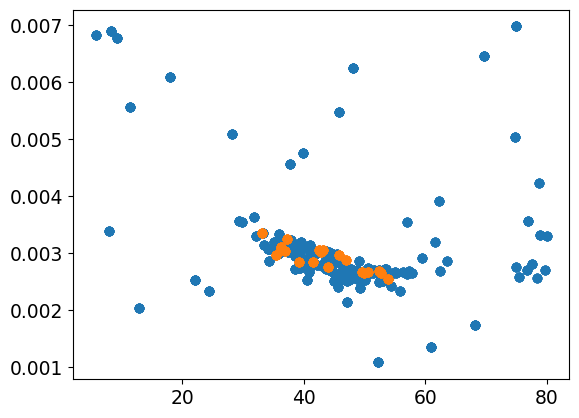

In [114]:
plt.scatter(X20_init[:,0],X20_init[:,1])
plt.scatter(X20_next[:,0],X20_next[:,1])

In [115]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset,RandomSampler

n_models = 50

Xtrain = torch.from_numpy(X20_init)
ytrain = torch.from_numpy(y20_init)
Xtest = torch.from_numpy(X20_next)
ytest = torch.from_numpy(y20_next)

class SimpleNN(nn.Module):
    def __init__(self,width=10):
        super(SimpleNN,self).__init__()
        self.width = width
        self.in_= nn.Linear(in_features=2,out_features=width)
        self.bn_ = nn.BatchNorm1d(num_features=2)
        self.relu_ = nn.ReLU()
        self.mid_ = nn.Linear(in_features=width,out_features=width)
        self.mid_2 = nn.Linear(in_features=width,out_features=width)
        self.out_ = nn.Linear(in_features=width,out_features=2)

    def forward(self,x):
        x = self.bn_(x)
        x = self.in_(x)
        x = self.relu_(x)
        x = self.mid_(x)
        x = self.relu_(x)
        x = self.mid_2(x)
        x = self.relu_(x)
        return self.out_(x)

ds = TensorDataset(Xtrain,ytrain)

    
emulators = [SimpleNN(width=50).double() for _ in range(n_models)]
optims = [ Adam(em.parameters(),lr=3e-5) for em in emulators]


In [128]:
idxs = [torch.multinomial(torch.ones(Xtrain.shape[0]),num_samples=int(len(Xtrain)/n_models),replacement=False) for _ in range(n_models)]

In [118]:
nepochs = 10000
losses = torch.zeros((nepochs,n_models))
for epoch in range(nepochs):
    for i,(em_i,opt_i) in enumerate(zip(emulators,optims)):
        train_points = Xtrain[idxs[i]]
        train_ys = ytrain[idxs[i]] 
        em_i.train()
        opt_i.zero_grad()
        ypred = em_i(train_points)
        loss = nn.functional.mse_loss(ypred,train_ys,reduction='mean')
        loss.backward()
        losses[epoch,i] = loss.detach()
        opt_i.step()

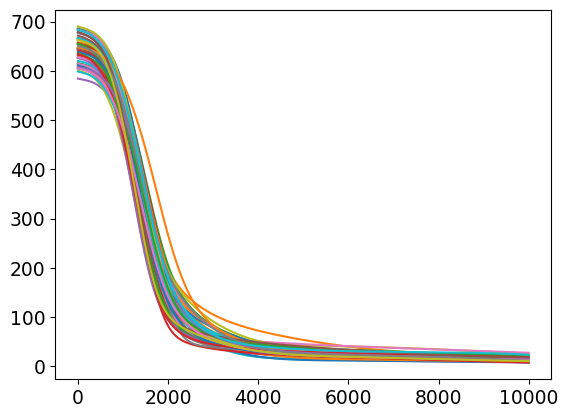

In [119]:

for j in range(n_models):
    plt.plot(losses[:,j])

In [120]:
with torch.no_grad():
    cw = torch.linspace(5,80,1000)
    bt = torch.linspace(0.001,0.007,1000)
    C,B = torch.meshgrid(cw,bt,indexing='xy') # IMPORTANT
    ins = torch.stack(torch.meshgrid(cw,bt,indexing='xy'),dim=-1).reshape(-1,2).double()
    outs = torch.zeros(n_models,1000*1000,2)
    for i,em in enumerate(emulators):
        em.eval()
        outs[i] = (em(ins))

    mean_out = torch.mean(outs,dim=0)
    stds_out = torch.std(outs,dim=0).reshape(1000,1000,2)[:,:,0].detach().numpy()


In [121]:
mean_out_period = mean_out.reshape(1000,1000,2)[:,:,0].detach().numpy()
mean_out_amp= mean_out.reshape(1000,1000,2)[:,:,1].detach().numpy()

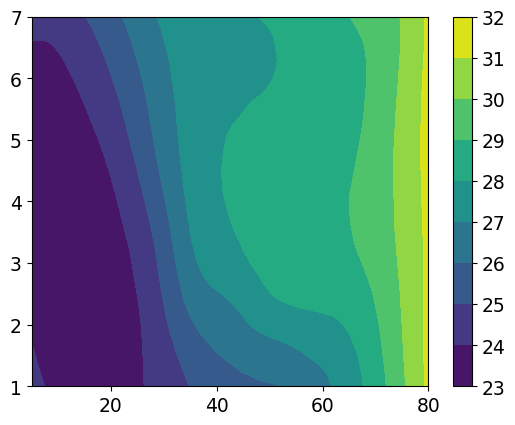

In [122]:
plt.contourf(cw.numpy(),bt.numpy()*1000,mean_out_period)
plt.colorbar()

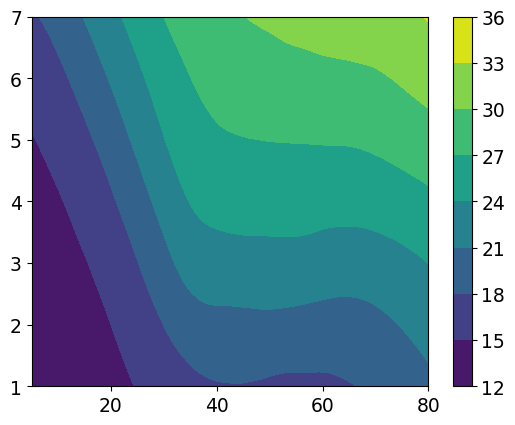

In [123]:
plt.contourf(cw.numpy(),bt.numpy()*1000,mean_out_amp)
plt.colorbar()

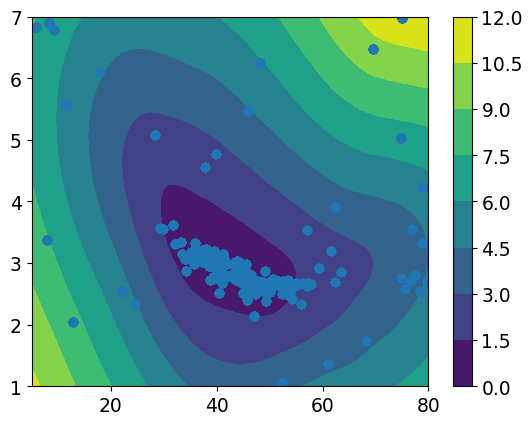

In [124]:
plt.contourf(cw.numpy(),bt.numpy()*1000,stds_out)
plt.colorbar()
plt.scatter(Xtrain[:,0],Xtrain[:,1]*1000)


Compare distributions at points


In [125]:
cwref,btref = Xtrain[0]
cwref,btref*1000

(tensor(34.2295, dtype=torch.float64), tensor(2.8661, dtype=torch.float64))

In [126]:
with torch.no_grad():
    samples = torch.zeros((n_models,2))
    for i,em in enumerate(emulators):
        em.eval()
        samples[i] = em(Xtrain[0][None,:])

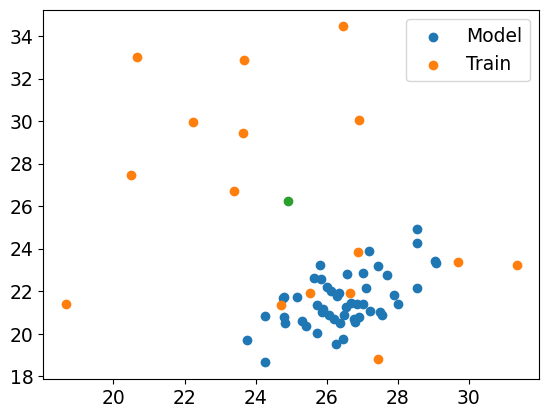

In [127]:
plt.scatter(samples[:,0],samples[:,1],label="Model")
plt.scatter(ytrain[:16,0],ytrain[:16,1],label="Train")
cwmean,btmean = ytrain[:16].mean(dim=0)
plt.scatter(cwmean,btmean) 
plt.legend()